
Training agent for growth stage: Cocoon
Episode 100/500, Total Reward: -125.60320668826498
Episode 200/500, Total Reward: -125.96010495174072
Episode 300/500, Total Reward: -125.77411034847239
Episode 400/500, Total Reward: -126.77346357512987
Episode 500/500, Total Reward: -125.7191911320155


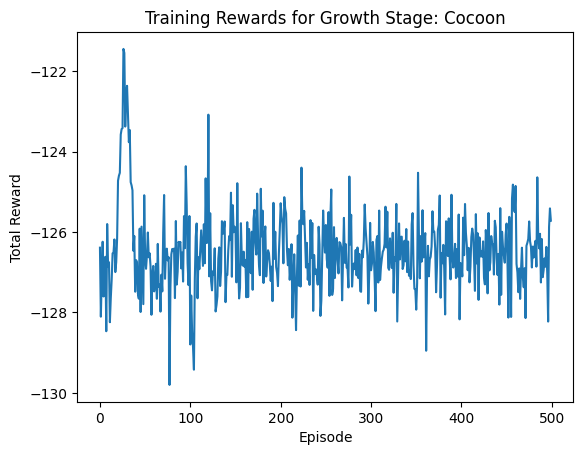


Training agent for growth stage: Larva
Episode 100/500, Total Reward: -125.63484670398864
Episode 200/500, Total Reward: -125.63240785427118
Episode 300/500, Total Reward: -126.66691793818421
Episode 400/500, Total Reward: -125.83016656798516
Episode 500/500, Total Reward: -126.30413328925005


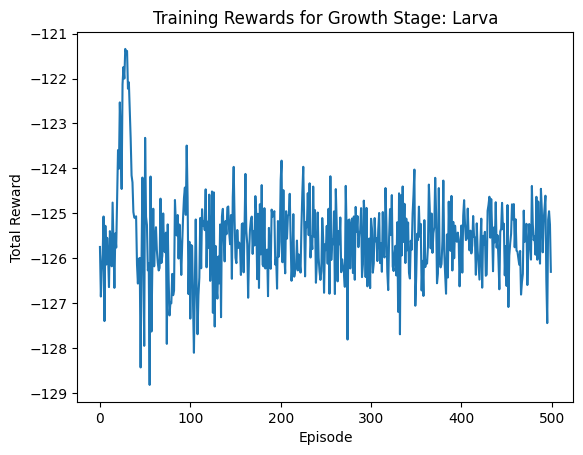


Training agent for growth stage: Egg
Episode 100/500, Total Reward: -132.70802237692254
Episode 200/500, Total Reward: -132.0494031607486
Episode 300/500, Total Reward: -131.92897155136095
Episode 400/500, Total Reward: -132.53564889652998
Episode 500/500, Total Reward: -133.4008652625883


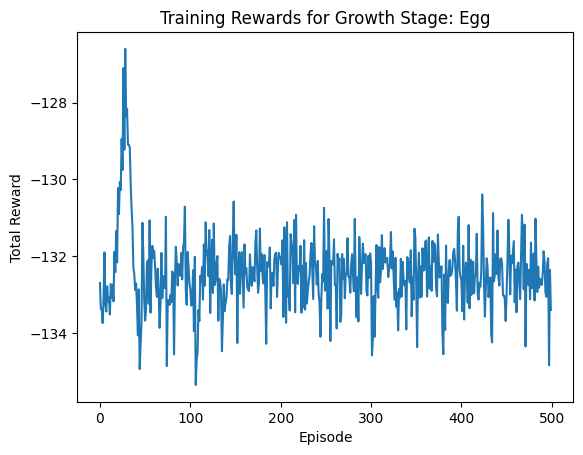


Training agent for growth stage: Pupa
Episode 100/500, Total Reward: -121.53233883334626
Episode 200/500, Total Reward: -120.6672072970653
Episode 300/500, Total Reward: -121.19657164489269
Episode 400/500, Total Reward: -120.86934006941014
Episode 500/500, Total Reward: -122.41324300930285


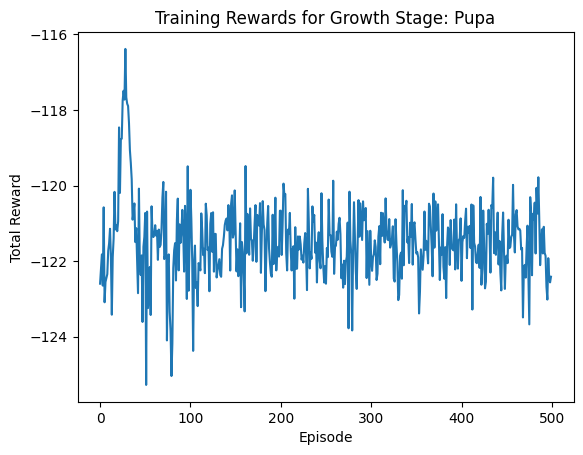


Optimal settings for growth stage: Cocoon
Temperature: 24.57, Humidity: 74.57

Optimal settings for growth stage: Larva
Temperature: 25.12, Humidity: 75.46

Optimal settings for growth stage: Egg
Temperature: 24.81, Humidity: 75.80

Optimal settings for growth stage: Pupa
Temperature: 25.11, Humidity: 74.99


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import os

# Step 1: Load and preprocess data
def preprocess_data(file_path="D:/Sericulture project/silkworm_data.csv"):
    data = pd.read_csv(file_path)

    # Normalize temperature and humidity
    scaler = MinMaxScaler()
    data[['temperature', 'humidity']] = scaler.fit_transform(data[['temperature', 'humidity']])

    return data, scaler

# Step 2: Define the environment
class SilkwormEnv:
    def __init__(self, data, growth_stage):
        self.data = data[data['growth_stage'] == growth_stage].reset_index(drop=True)
        self.current_step = 0
        self.action_space = 5
        self.state_space = 2

    def reset(self):
        self.current_step = 0
        state = self.data.iloc[self.current_step][['temperature', 'humidity']].values
        return state

    def step(self, action):
        temp, humidity = self.data.iloc[self.current_step][['temperature', 'humidity']]

        if action == 0:
            temp = min(1, temp + 0.05)
        elif action == 1:
            temp = max(0, temp - 0.05)
        elif action == 2:
            humidity = min(1, humidity + 0.05)
        elif action == 3:
            humidity = max(0, humidity - 0.05)

        avg_temp = self.data['temperature'].mean()
        avg_humidity = self.data['humidity'].mean()
        reward = -abs(temp - avg_temp) - abs(humidity - avg_humidity)

        self.current_step += 1
        done = self.current_step >= len(self.data)
        next_state = np.array([temp, humidity]) if not done else None

        return next_state, reward, done

# Step 3: Q-learning Agent
class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.state_space = state_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = defaultdict(float)

    def select_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.action_space - 1)
        else:
            q_values = [self.q_table[(tuple(state), a)] for a in range(self.action_space)]
            return np.argmax(q_values)

    def update(self, state, action, reward, next_state):
        current_q = self.q_table[(tuple(state), action)]
        max_next_q = max([self.q_table[(tuple(next_state), a)] for a in range(self.action_space)], default=0)
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[(tuple(state), action)] = new_q

# Step 4: Train the agent
def train_agent(data, growth_stage, episodes=500):
    env = SilkwormEnv(data, growth_stage)
    agent = QLearningAgent(state_space=env.state_space, action_space=env.action_space)

    rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, done = env.step(action)
            if not done:
                agent.update(state, action, reward, next_state)
            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

    # Plot rewards
    plt.plot(rewards)
    plt.title(f"Training Rewards for Growth Stage: {growth_stage}")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

    return agent

# Step 5: Main execution
def main():
    # ✅ Direct local file path instead of Colab upload
    file_path = "D:/Sericulture project/silkworm_data.csv"
    
    if not os.path.exists(file_path):
        print(f"Error: Dataset file not found at {file_path}")
        return

    data, scaler = preprocess_data(file_path)
    growth_stages = data['growth_stage'].unique()

    agents = {}
    for stage in growth_stages:
        print(f"\nTraining agent for growth stage: {stage}")
        agent = train_agent(data, stage)
        agents[stage] = agent

    # Output optimal settings
    for stage, agent in agents.items():
        print(f"\nOptimal settings for growth stage: {stage}")
        avg_temp = data[data['growth_stage'] == stage]['temperature'].mean()
        avg_humidity = data[data['growth_stage'] == stage]['humidity'].mean()
        temp_humidity = scaler.inverse_transform([[avg_temp, avg_humidity]])
        print(f"Temperature: {temp_humidity[0][0]:.2f}, Humidity: {temp_humidity[0][1]:.2f}")

if __name__ == "__main__":
    main()
